# WordGame data analysis

Welcome to my WordGame project! In this first notebook, our goal is to extract interesting features from the Wordgame dataset, a dataset containing 0.3M word-word associations scraped from Word Association Games running on 10 internet forums. Finding meaningful features in this dataset is necessary to build a classification model and in itself may already provide novel insights into the human mind. 

Let's open up the dataset.

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#df = pd.read_csv('../input/wordgame_201706.csv')
df = pd.read_csv('../data/processed/wordgame_201706.csv', dtype='object')
#store words as string
df['word1'] = df['word1'].astype('str') 
df['word2'] = df['word2'].astype('str') 
#print first rows
df.head()

,author,word1,word2,source
0,4688,Crows,Feet,the_fishy
1,4841,Salute,Respect,the_fishy
2,1732,Pride,Arrogance,gog
3,1272,knife,butter,gog
4,418,Bed Head,My hair right now,atu2


The dataset contains 4 columns; author, word1, word2 and source. Word1 and word2 can also be a phrase or in some cases even a whole sentence. In each row, word1 is the given word and word2 is the word-association the **author** had after reading that word. Source represents from which forum the information was scraped. Note that the set words 'word1' is identical to the set 'word2', except for some small differences due to dropping some word pairs in the data cleaning process, since a word association game is basically a long chain of words in which each new word is always followed by a next association and so on. Also note, that a 'word' usually consists of only one term, but it can also be a phrase (e.g. Game of Thrones) or in some cases a whole sentence.  

## Sources
We have data from 10 sources, respectively <a href="https://www.aspiescentral.com">Aspies Central</a>, <a href="forum.atu2.com">@U2</a>, <a href="bleepingcomputer.com">BleepingComputer</a>, <a href="classiccomics.org">Classic Comics</a>, <a href="https://www.e-cigarette-forum.com">ECF</a>, GOG, <a href="http://learn-english-forum.org/">Learn English Forum</a>, SAS, The Fishy and <a href="www.wrongplanet.net">Wrong Planet</a>. We do not know details like the gender and the age of the users of the different online communities, so even if we would be able to build a multi-class classification model that can classify all pairs with 100% accuracy, we still would be unable to make any conclusions. 

However, 23% of the data was purposely scraped from autism-related websites, Aspies Central (SourceID: 0) and Wrong Planet (SourceID: 9). Research has shown that persons with an ASD have different brain structure and functionality compared to persons with a neuro-typical (NT) brain, which may lead to different behaviour whilst playing an online Word Association Game. Since we do not have of diagnosical data of all persons in the dataset, we will make the assumption that everyone from the Aspies Central community and the Wrong Planet commununity has autism, and all users from other communities do not have autism. In reality approximately 10% of all people have autism, who will offcourse also be present on non-autism related websites, while also not everyone in a autism-related community has autism themselves (for example NT parents seeking for advise for their autistic child). Thus this assumption will be approximately 90% correct.

In [68]:
# create a source ID 
df['sourceID'] = df['source'].astype('category').cat.codes

#returns False for sources 0 and 9 and True for others. 
def isNt(r):
	return ((r.sourceID%9)>0)

#group sources based on (assumed) brain-structure of their users (neural-typical versus ASD)
df['nt'] = df.apply(isNt, axis=1)
print("Number of NT-pairs: " + str(len(df[df['nt']])))
print("Number of ASD-pairs: " + str(len(df[df['nt']==False])))

Number of NT-pairs: 259770
Number of ASD-pairs: 74242


## Word length
We are now ready to extract our first feature, which will be the word length. I do not expect any differences between NT'ers and ASD'ers, although I'm curious to what is the average length of English words. 

Longest word: 200


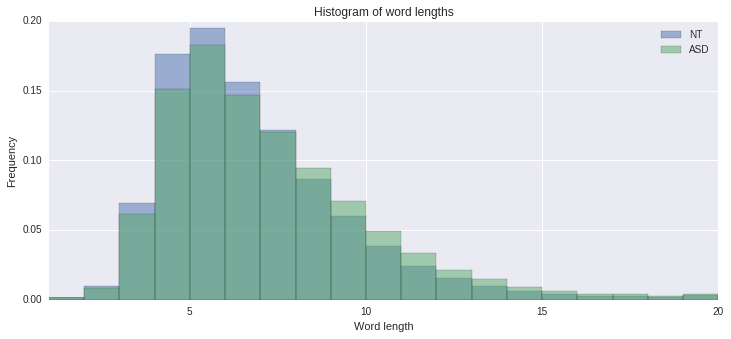

In [69]:
df['len1'] = df['word1'].apply(lambda x:len(x))
df['len2'] = df['word2'].apply(lambda x:len(x))
print("Longest word: " +str(df['len1'].max()))

## plot word length histogram
nt = df[df['nt']].len1
asd = df[df['nt']==False].len1

w1 = np.ones_like(nt)/len(nt)
w2 = np.ones_like(asd)/len(asd)

bins = np.arange(1,21)

plt.figure(figsize=(12, 5))
plt.hist(nt, bins=bins, alpha=0.5, label="NT", weights=w1)
plt.hist(asd, bins=bins,alpha=0.5, label="ASD", weights=w2)
plt.title('Histogram of word lengths')
plt.xlabel('Word length')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
axes = plt.gca()
axes.set_xlim([1,20])
plt.show()

A post contains on average 7 characters. Most words are between 3 and 15 characters long. The longest word (although it is probably a sentence) is 200 characters long. Interestingly, both NT'ers and ASD'ers use words with exactly 7 characters with similar frequency although **ASD'ers tend to use words shorter than 7 characters less frequently and longer words slightly more frequently.**

## User activity
Another highly important aspect is the number and distribution of users, because ultimately we want to develop a generalizable model and not a model that models the the difference between user A and user B. Fortunately, we have a very large dataset, which makes the distribution of users a little less important. 

Post count of most active user: 11053
Total number of users: 6256
	Number of NT'ers: 4482
	Number of ASD'ers: 1774


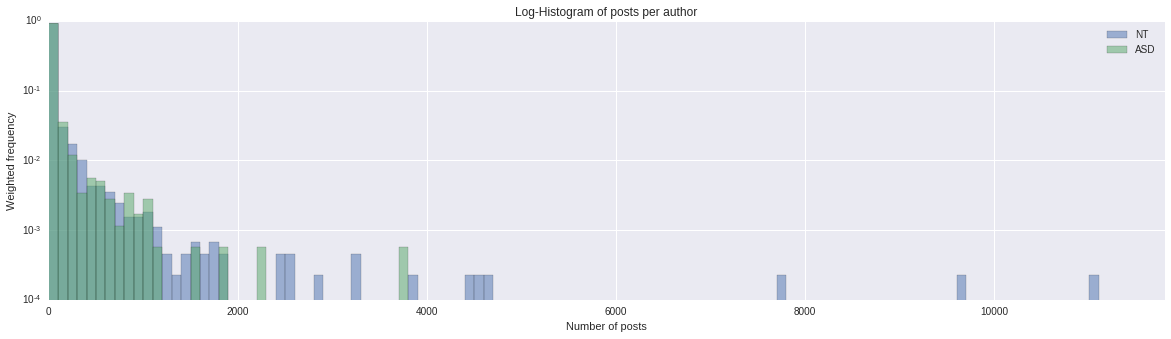

In [24]:
#
print("Post count of most active user: " + str(df['author'].value_counts().max()))
print("Total number of users: " + str(len(df.groupby(['author']))))

nt = df[df['nt']]
asd = df[df['nt']==False]
nt = nt['author'].value_counts()
asd = asd['author'].value_counts()

print("\tNumber of NT'ers: " + str(len(nt)))
print("\tNumber of ASD'ers: " + str(len(asd)))

bins = np.arange(1,11800,100)
w1 = np.ones_like(nt)/len(nt)
w2 = np.ones_like(asd)/len(asd)

#Plot
plt.figure(figsize=(20, 5))
plt.hist(nt, bins=bins, alpha=0.5, label="NT", weights=w1)
plt.hist(asd, bins=bins, alpha=0.5, label="ASD", weights=w2)
plt.yscale('log')
plt.title('Log-Histogram of posts per author')
plt.xlabel('Number of posts')
plt.ylabel('Weighted frequency')
plt.legend(loc='upper right')
axes = plt.gca()
axes.set_xlim([1,11800])
plt.show()

Fortunately, almost 100% of all users in both datasets have 100 or less posts. However, there are are also 3 users in the NT set who have more than 7000 posts each, one of these users even has 11053 posts, accounting for 5% of the whole NT dataset. I think he is bit obsessed with the word game.. It might be better randomly drop most of their posts from the dataset, but for now I will leave them in. 

## Frequent words
So far we know that we have more 300000 posts from more than 6000 users, but what are the most frequently occurring words? Will these words be very meaningful or just random?

In [72]:
# convert all words to lowercase
df['word1'] = df['word1'].map(str).apply(lambda x: x.lower())
df['word2'] = df['word2'].map(str).apply(lambda x: x.lower())

# split NT and ASD data
nt = df[df['nt']]
asd = df[df['nt']==False]

#word count
print("NT'ers most frequent words:\n" + str(nt['word2'].value_counts().head(10)))
print("ASD'ers most frequent words:\n" + str(asd['word2'].value_counts().head(10)))

NT'ers most frequent words:
water    488
time     437
music    404
love     364
fire     340
house    337
ball     334
money    332
game     330
man      330
Name: word2, dtype: int64
ASD'ers most frequent words:
water    159
food     131
music    130
money    122
death    112
dog      107
fire     106
time     101
love      95
blood     92
Name: word2, dtype: int64


The most frequent words are definitely meaningful and **NT'ers and ASD'ers seem to use the same words most frequently.** Both groups even agree that *water* is (by far) the most important word of all and that *music* is the third most important word. 

## Levenshtein Distance
We can expect that the pairs word1-word2 contain the most the most information about the human mind. For example, when someone says *rice* you might say *food* whereas I might say *mice* (because rice sounds like mice). Which of these types of word associations can be considered to be more typically autistic?

To determine this, we will use the **Levensthein Distance** (also called edit distance), which measures the similarity of two words by counting the minimum number of character *edits* (insertion, deletion or substitution) required to change one word into the other. In our example rice->food will has edit distance 4, whereas rice->mice has edit distance 1.  

In [73]:
import Levenshtein

def levenshtein(r):
	return Levenshtein.distance(r.word1, r.word2)

#calculate levenstein distance on each row and add to dataframe
df['edit'] = df.apply(levenshtein, axis=1)

#print mean edit distance
print("Mean edit distance: "+ str(df['edit'].mean()))

Mean edit distance: 6.81435996312


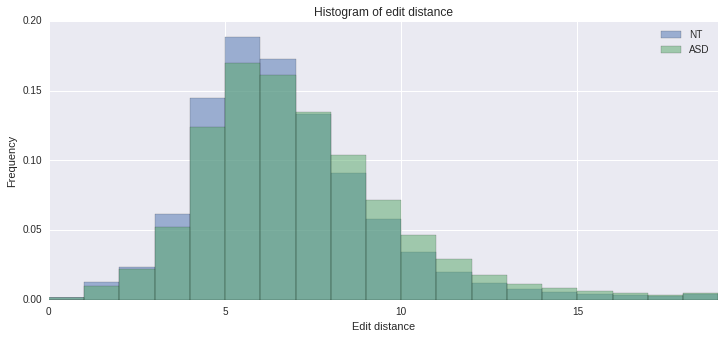

In [81]:
#delete outliers in terms of word length
#df = df[(2 < df['len1']) & (df['len1'] < 18) & (2 < df['len2']) & (df['len2'] < 18)]

#split data into NT and ASD set
nt = df[(df['nt'] == True)]
asd = df[(df['nt'] == False)]

bins = np.arange(0,20)
weights_nt = np.ones_like(nt['edit'])/len(nt['edit'])
weights_asd = np.ones_like(asd['edit'])/len(asd['edit'])

#Plot
plt.figure(figsize=(12, 5))
plt.hist(nt['edit'], bins=bins, alpha=0.5, label="NT", weights=weights_nt)
plt.hist(asd['edit'], bins=bins, alpha=0.5, label="ASD", weights=weights_asd)
plt.title('Histogram of edit distance')
plt.xlabel('Edit distance')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
axes = plt.gca()
axes.set_xlim([0,19])
plt.show()

The edit distance distribution is consistent with the word length distribution, thus there are **no differences between NT'ers and ASD'ers in terms of edit distance.**

In [ ]:
Next notebook..